<a href="https://colab.research.google.com/github/ilman79/Case-Study-02-Data-Mining-UIN-Ganjil-2022-Kelompok-1/blob/main/Development_Machine_Learning_with_CNN.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
! pip install kaggle

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [3]:
from google.colab import files
files.upload()

Saving kaggle.json to kaggle.json


{'kaggle.json': b'{"username":"gifariilman","key":"5c2fca0d1e6e17444d289ca2575e590e"}'}

In [4]:
! mkdir -p ~/.kaggle
! cp kaggle.json ~/.kaggle/
! chmod 600 ~/.kaggle/kaggle.json

In [5]:
!kaggle datasets download -d valentynsichkar/traffic-signs-preprocessed

100% 4.15G/4.16G [00:49<00:00, 132MB/s]
100% 4.16G/4.16G [00:49<00:00, 89.6MB/s]


In [6]:
!unzip /content/traffic-signs-preprocessed.zip -d /content/sample_data

Archive:  /content/traffic-signs-preprocessed.zip
  inflating: /content/sample_data/data0.pickle  
  inflating: /content/sample_data/data1.pickle  
  inflating: /content/sample_data/data2.pickle  
  inflating: /content/sample_data/data3.pickle  
  inflating: /content/sample_data/data4.pickle  
  inflating: /content/sample_data/data5.pickle  
  inflating: /content/sample_data/data6.pickle  
  inflating: /content/sample_data/data7.pickle  
  inflating: /content/sample_data/data8.pickle  
  inflating: /content/sample_data/datasets_preparing.py  
  inflating: /content/sample_data/label_names.csv  
  inflating: /content/sample_data/labels.pickle  
  inflating: /content/sample_data/mean_image_gray.pickle  
  inflating: /content/sample_data/mean_image_rgb.pickle  
  inflating: /content/sample_data/std_gray.pickle  
  inflating: /content/sample_data/std_rgb.pickle  
  inflating: /content/sample_data/test.pickle  
  inflating: /content/sample_data/train.pickle  
  inflating: /content/sample_dat

In [1]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import pickle
import matplotlib.pyplot as plt
from timeit import default_timer as timer

from keras.utils.np_utils import to_categorical
from keras.models import Sequential
from keras.layers import Dense, Dropout, Flatten, Conv2D, MaxPool2D, AvgPool2D, BatchNormalization, Reshape
from keras.preprocessing.image import ImageDataGenerator
from keras.callbacks import LearningRateScheduler

In [7]:
# Opening file for reading in binary mode
with open('/content/sample_data/data2.pickle', 'rb') as f:
    data = pickle.load(f, encoding='latin1')  # dictionary type

# Preparing y_train and y_validation for using in Keras
data['y_train'] = to_categorical(data['y_train'], num_classes=43)
data['y_validation'] = to_categorical(data['y_validation'], num_classes=43)

# Making channels come at the end
data['x_train'] = data['x_train'].transpose(0, 2, 3, 1)
data['x_validation'] = data['x_validation'].transpose(0, 2, 3, 1)
data['x_test'] = data['x_test'].transpose(0, 2, 3, 1)

# Showing loaded data from file
for i, j in data.items():
    if i == 'labels':
        print(i + ':', len(j))
    else: 
        print(i + ':', j.shape)

# x_train: (86989, 32, 32, 3)
# y_train: (86989, 43)
# x_test: (12630, 32, 32, 3)
# y_test: (12630,)
# x_validation: (4410, 32, 32, 3)
# y_validation: (4410, 43)
# labels: 43

y_test: (12630,)
y_validation: (4410, 43)
x_validation: (4410, 32, 32, 3)
x_train: (86989, 32, 32, 3)
y_train: (86989, 43)
labels: 43
x_test: (12630, 32, 32, 3)


(81, 32, 32, 3)


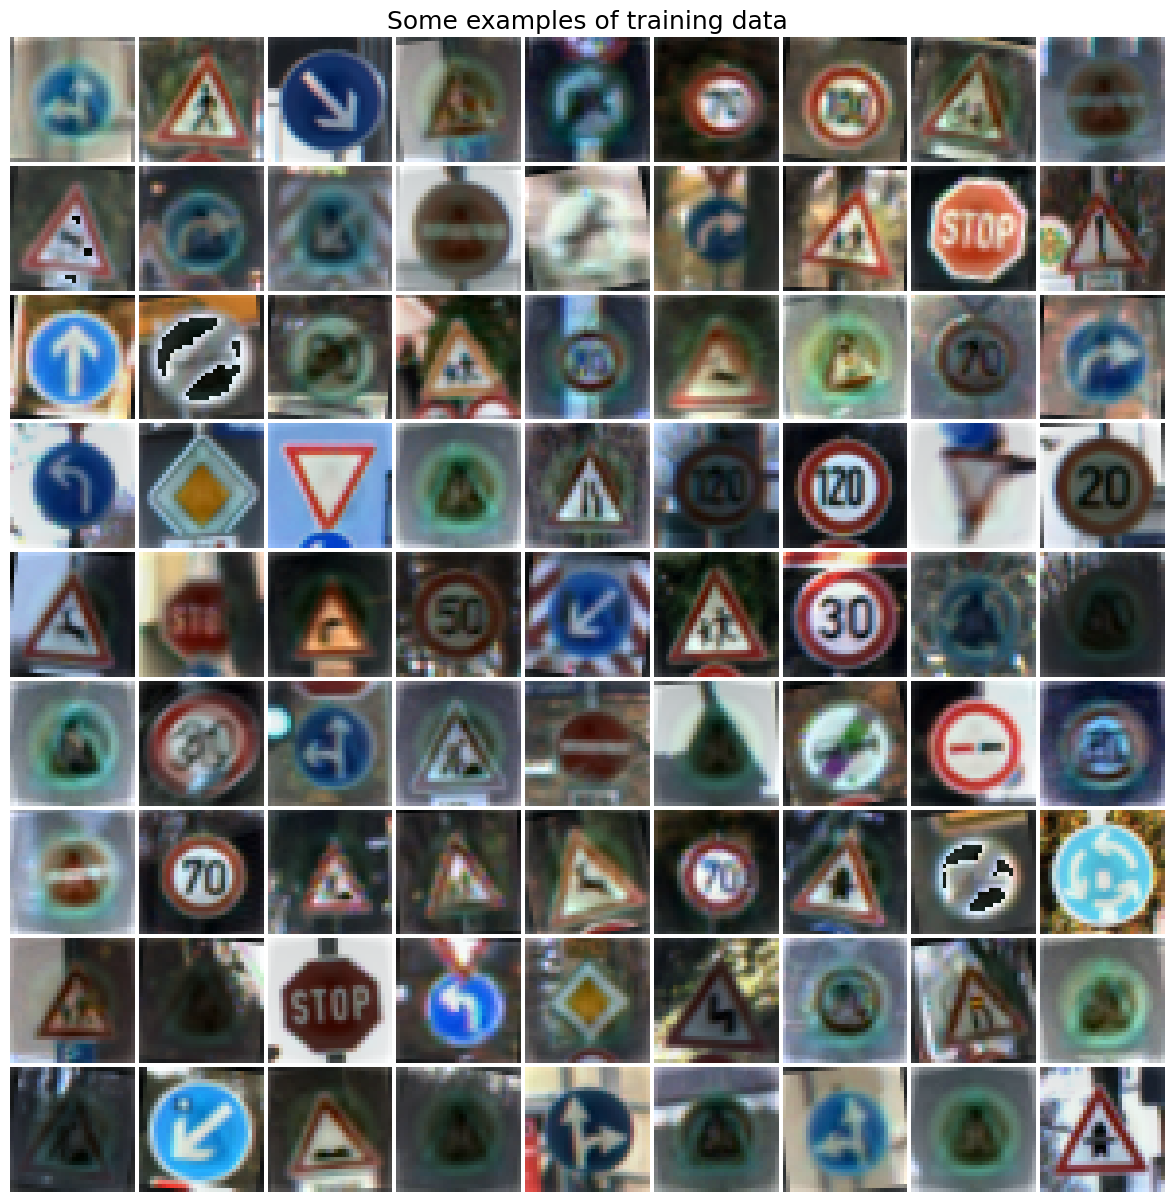

In [8]:
%matplotlib inline

# Preparing function for ploting set of examples
# As input it will take 4D tensor and convert it to the grid
# Values will be scaled to the range [0, 255]
def convert_to_grid(x_input):
    N, H, W, C = x_input.shape
    grid_size = int(np.ceil(np.sqrt(N)))
    grid_height = H * grid_size + 1 * (grid_size - 1)
    grid_width = W * grid_size + 1 * (grid_size - 1)
    grid = np.zeros((grid_height, grid_width, C)) + 255
    next_idx = 0
    y0, y1 = 0, H
    for y in range(grid_size):
        x0, x1 = 0, W
        for x in range(grid_size):
            if next_idx < N:
                img = x_input[next_idx]
                low, high = np.min(img), np.max(img)
                grid[y0:y1, x0:x1] = 255.0 * (img - low) / (high - low)
                next_idx += 1
            x0 += W + 1
            x1 += W + 1
        y0 += H + 1
        y1 += H + 1

    return grid


# Visualizing some examples of training data
examples = data['x_train'][:81, :, :, :]
print(examples.shape)  # (81, 32, 32, 3)

# Plotting some examples
fig = plt.figure()
grid = convert_to_grid(examples)
plt.imshow(grid.astype('uint8'), cmap='gray')
plt.axis('off')
plt.gcf().set_size_inches(15, 15)
plt.title('Some examples of training data', fontsize=18)

# Showing the plot
plt.show()

# Saving the plot
fig.savefig('training_examples.png')
plt.close()

In [9]:
model = Sequential()
model.add(Conv2D(32, kernel_size=3, padding='same', activation='relu', input_shape=(32, 32, 3)))
model.add(MaxPool2D(pool_size=2))
model.add(Flatten())
model.add(Dense(500, activation='relu'))
model.add(Dense(43, activation='softmax'))
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

In [10]:
annealer = LearningRateScheduler(lambda x: 1e-3 * 0.95 ** (x + epochs))
epochs = 15

h = model.fit(data['x_train'][:10], data['y_train'][:10],
              batch_size=5, epochs = epochs,
              validation_data = (data['x_validation'], data['y_validation']),
              callbacks=[annealer], verbose=1)

Epoch 1/15
2/2 [==============================] - 10s 7s/step - loss: 3.7941 - accuracy: 0.0000e+00 - val_loss: 3.8212 - val_accuracy: 0.0238 - lr: 4.6329e-04
Epoch 2/15
2/2 [==============================] - 10s 10s/step - loss: 3.0382 - accuracy: 0.4000 - val_loss: 4.0095 - val_accuracy: 0.0406 - lr: 4.4013e-04
Epoch 3/15
2/2 [==============================] - 10s 10s/step - loss: 2.4365 - accuracy: 0.5000 - val_loss: 4.4954 - val_accuracy: 0.0422 - lr: 4.1812e-04
Epoch 4/15
2/2 [==============================] - 10s 10s/step - loss: 1.9851 - accuracy: 0.5000 - val_loss: 5.1258 - val_accuracy: 0.0372 - lr: 3.9721e-04
Epoch 5/15
2/2 [==============================] - 11s 10s/step - loss: 1.6359 - accuracy: 0.5000 - val_loss: 5.8275 - val_accuracy: 0.0331 - lr: 3.7735e-04
Epoch 6/15
2/2 [==============================] - 8s 8s/step - loss: 1.3971 - accuracy: 0.6000 - val_loss: 6.5054 - val_accuracy: 0.0340 - lr: 3.5849e-04
Epoch 7/15
2/2 [==============================] - 6s 6s/step - 

In [23]:
print('Epochs={0:d}, training accuracy={1:.5f}, validation accuracy={2:.5f}'.\
      format(epochs, max(h.history['accuracy']), max(h.history['val_accuracy'])))

Epochs=15, training accuracy=1.00000, validation accuracy=0.04218


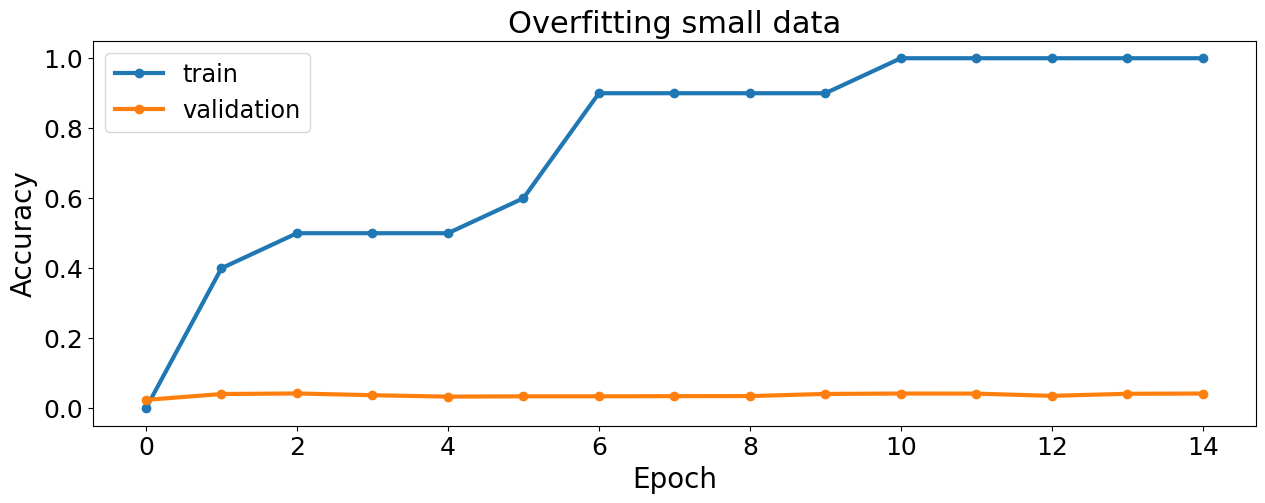

In [24]:
%matplotlib inline
plt.rcParams['figure.figsize'] = (15.0, 5.0) # Setting default size of plots
plt.rcParams['image.interpolation'] = 'nearest'

fig = plt.figure()
plt.plot(h.history['accuracy'], '-o', linewidth=3.0)
plt.plot(h.history['val_accuracy'], '-o', linewidth=3.0)
plt.title('Overfitting small data', fontsize=22)
plt.legend(['train', 'validation'], loc='upper left', fontsize='xx-large')
plt.xlabel('Epoch', fontsize=20)
plt.ylabel('Accuracy', fontsize=20)
plt.tick_params(labelsize=18)

# Showing the plot
plt.show()

# Saving the plot
fig.savefig('overfitting_small_data.png')
plt.close()

In [25]:
filters = [3, 5, 9, 13, 15, 19, 23, 25, 31]
model = [0] * len(filters)

for i in range(len(model)):
    model[i] = Sequential()
    model[i].add(Conv2D(32, kernel_size=filters[i], padding='same', activation='relu', input_shape=(32, 32, 3)))
    model[i].add(MaxPool2D(pool_size=2))
    model[i].add(Flatten())
    model[i].add(Dense(500, activation='relu'))
    model[i].add(Dense(43, activation='softmax'))
    model[i].compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

In [28]:
annealer = LearningRateScheduler(lambda x: 1e-3 * 0.95 ** (x + epochs))
epochs = 5

h = [0] * len(model)

for i in range(len(h)):
    h[i] = model[i].fit(data['x_train'], data['y_train'],
                        batch_size=5, epochs = epochs,
                        validation_data = (data['x_validation'], data['y_validation']),
                        callbacks=[annealer], verbose=0)
    
    print('Model with filters {0:d}x{0:d}, epochs={1:d}, training accuracy={2:.5f}, validation accuracy={3:.5f}'.\
      format(filters[i], epochs, max(h[i].history['accuracy']), max(h[i].history['val_accuracy'])))

KeyboardInterrupt: ignored

AttributeError: ignored

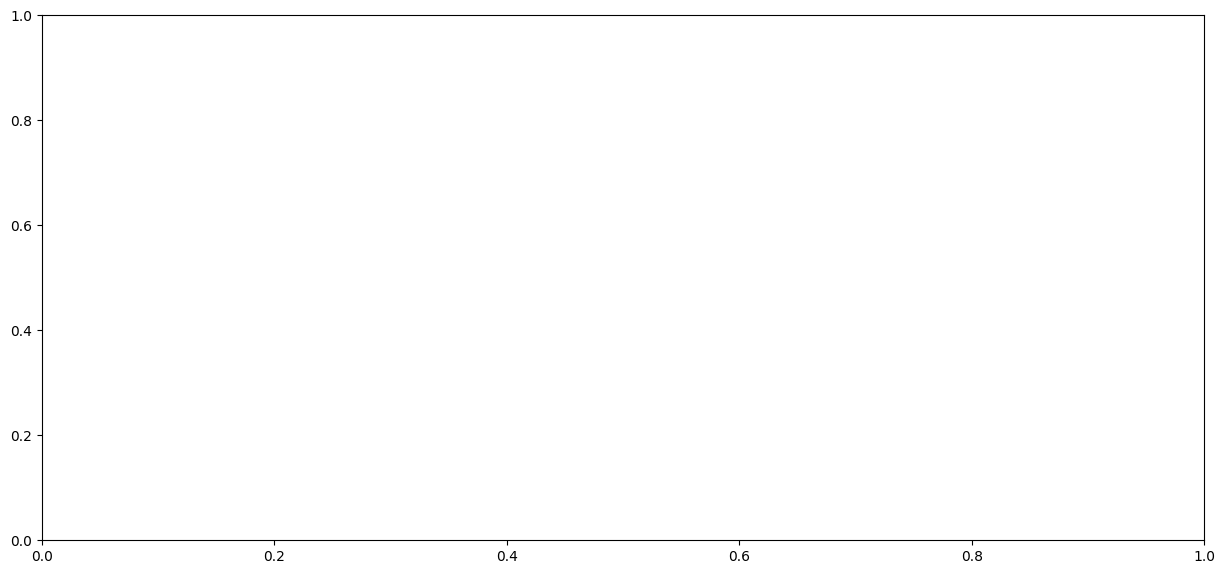

In [35]:
%matplotlib inline
plt.rcParams['figure.figsize'] = (15.0, 15.0) # Setting default size of plots
plt.rcParams['image.interpolation'] = 'nearest'

# Plotting history of training accuracy
fig = plt.figure()
plt.subplot(2, 1, 1)
plt.plot(h[8].history['accuracy'], '-o', linewidth=3.0)
plt.plot(h[7].history['accuracy'], '-s', linewidth=3.0)
plt.plot(h[6].history['accuracy'], '-D', linewidth=3.0)
plt.plot(h[5].history['accuracy'], '-D', linewidth=3.0)
plt.plot(h[4].history['accuracy'], '-o', linewidth=3.0)
plt.plot(h[3].history['accuracy'], '-o', linewidth=3.0)
plt.plot(h[2].history['accuracy'], '-o', linewidth=3.0)
plt.plot(h[1].history['accuracy'], '-o', linewidth=3.0)
plt.plot(h[0].history['accuracy'], '-o', linewidth=3.0)
plt.legend(['filter 31', 'filter 25', 'filter 23', 'filter 19', 'filter 15', 'filter 13', 'filter 9', 'filter 5', 'filter 3'], loc='lower right', fontsize='xx-large', borderpad=2)
plt.xlabel('Epoch', fontsize=20)
plt.ylabel('Training Accuracy', fontsize=20)
plt.yscale('linear')  # {"linear", "log", "symlog", "logit", ...}
plt.ylim(0.85, 1.0)
plt.xlim(0.5, 5.3) 
plt.title('Accuracy for different sizes of filters', fontsize=22)
plt.tick_params(labelsize=18)

plt.subplot(2, 1, 2)
# plt.gca().set_title('Validation accuracy')
plt.plot(h[8].history['val_accuracy'], '-o', linewidth=3.0)
plt.plot(h[7].history['val_accuracy'], '-s', linewidth=3.0)
plt.plot(h[6].history['val_accuracy'], '-D', linewidth=3.0)
plt.plot(h[5].history['val_accuracy'], '-D', linewidth=3.0)
plt.plot(h[4].history['val_accuracy'], '-o', linewidth=3.0)
plt.plot(h[3].history['val_accuracy'], '-o', linewidth=3.0)
plt.plot(h[2].history['val_accuracy'], '-o', linewidth=3.0)
plt.plot(h[1].history['val_accuracy'], '-o', linewidth=3.0)
plt.plot(h[0].history['val_accuracy'], '-o', linewidth=3.0)
plt.legend(['filter 31', 'filter 25', 'filter 23', 'filter 19', 'filter 15', 'filter 13', 'filter 9', 'filter 5', 'filter 3'], loc='lower right', fontsize='xx-large', borderpad=2)
plt.xlabel('Epoch', fontsize=20)
plt.ylabel('Validation Accuracy', fontsize=20)
plt.yscale('linear')  # {"linear", "log", "symlog", "logit", ...}
plt.ylim(0.75, 0.9)
plt.xlim(0.5, 5.3)
plt.tick_params(labelsize=18)

# Showing the plot
plt.show()

# Saving the plot
fig.savefig('models_accuracy.png')
plt.close()


# Showing values of accuracy for different filters
for i in range(len(h)):
    print('data2 filter {0:d} training accuracy = {1:.5f}'.\
          format(filters[i], np.max(h[i].history['accuracy'])))

print()

for i in range(len(h)):
    print('data2 filter {0:d} validation accuracy = {1:.5f}'.\
          format(filters[i], np.max(h[i].history['val_accuracy'])))

In [33]:
for i in range(len(model)):
    temp = model[i].predict(data['x_test'])
    temp = np.argmax(temp, axis=1)

    # We compare predicted class with correct class for all input images
    # And calculating mean value among all values of following numpy array
    # By saying 'testing_accuracy == data['y_test']' we create numpy array with True and False values
    # 'np.mean' function will return average of the array elements
    # The average is taken over the flattened array by default
    temp = np.mean(temp == data['y_test'])
    
    print('data2 filter {0:d} testing accuracy = {1:.5f}'.format(filters[i], temp))

395/395 [==============================] - 9s 23ms/step
data2 filter 3 testing accuracy = 0.88630
395/395 [==============================] - 9s 24ms/step
data2 filter 5 testing accuracy = 0.03310
395/395 [==============================] - 13s 34ms/step
data2 filter 9 testing accuracy = 0.02629
395/395 [==============================] - 22s 54ms/step
data2 filter 13 testing accuracy = 0.02098
395/395 [==============================] - 30s 76ms/step
data2 filter 15 testing accuracy = 0.01267
395/395 [==============================] - 44s 110ms/step
data2 filter 19 testing accuracy = 0.03048
395/395 [==============================] - 64s 162ms/step
data2 filter 23 testing accuracy = 0.01560
395/395 [==============================] - 80s 203ms/step
data2 filter 25 testing accuracy = 0.01330
395/395 [==============================] - 125s 315ms/step
data2 filter 31 testing accuracy = 0.01568


In [32]:
# Getting scores from forward pass of one input image
# Scores are given for each image with 43 numbers of predictions for each class
# Measuring at the same time execution time

for i in range(len(model)):
    start = timer()
    temp = model[i].predict(data['x_test'][:1, :, :, :])
    end = timer()
    
    print('data2 filter {0:d} classification time = {1:.5f}'.format(filters[i], end - start))

1/1 [==============================] - 0s 32ms/step
data2 filter 3 classification time = 0.09789
1/1 [==============================] - 0s 94ms/step
data2 filter 5 classification time = 0.16332
1/1 [==============================] - 0s 84ms/step
data2 filter 9 classification time = 0.15371
1/1 [==============================] - 0s 92ms/step
data2 filter 13 classification time = 0.15674


1/1 [==============================] - 0s 99ms/step
data2 filter 15 classification time = 0.16029


1/1 [==============================] - 0s 89ms/step
data2 filter 19 classification time = 0.16268
1/1 [==============================] - 0s 91ms/step
data2 filter 23 classification time = 0.14560
1/1 [==============================] - 0s 74ms/step
data2 filter 25 classification time = 0.13297
1/1 [==============================] - 0s 81ms/step
data2 filter 31 classification time = 0.12686


(3, 3, 3, 32)
(32, 3, 3, 3)


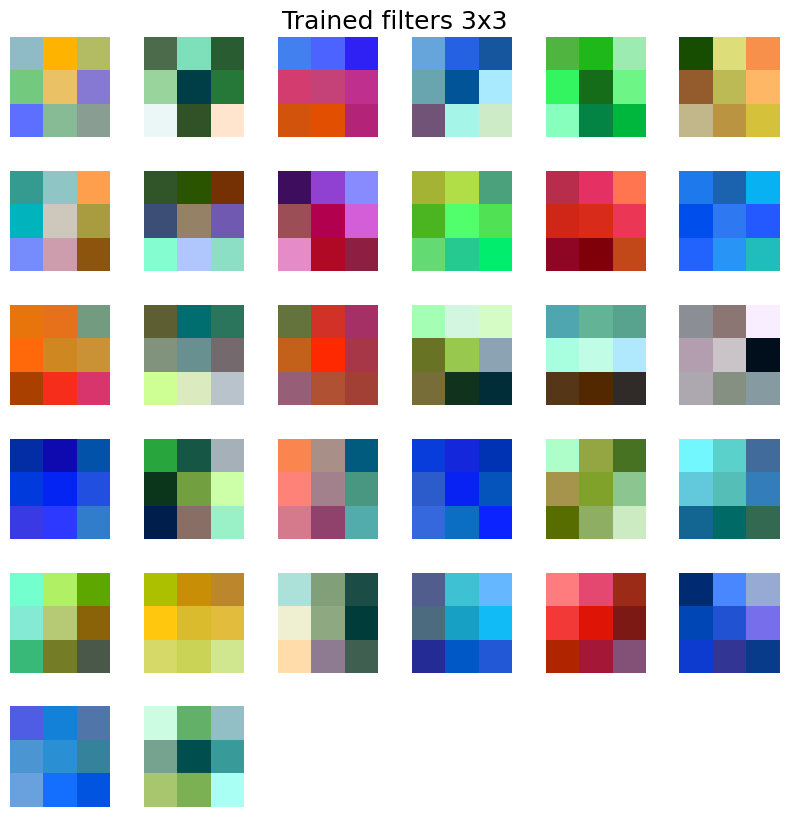

(5, 5, 3, 32)
(32, 5, 5, 3)


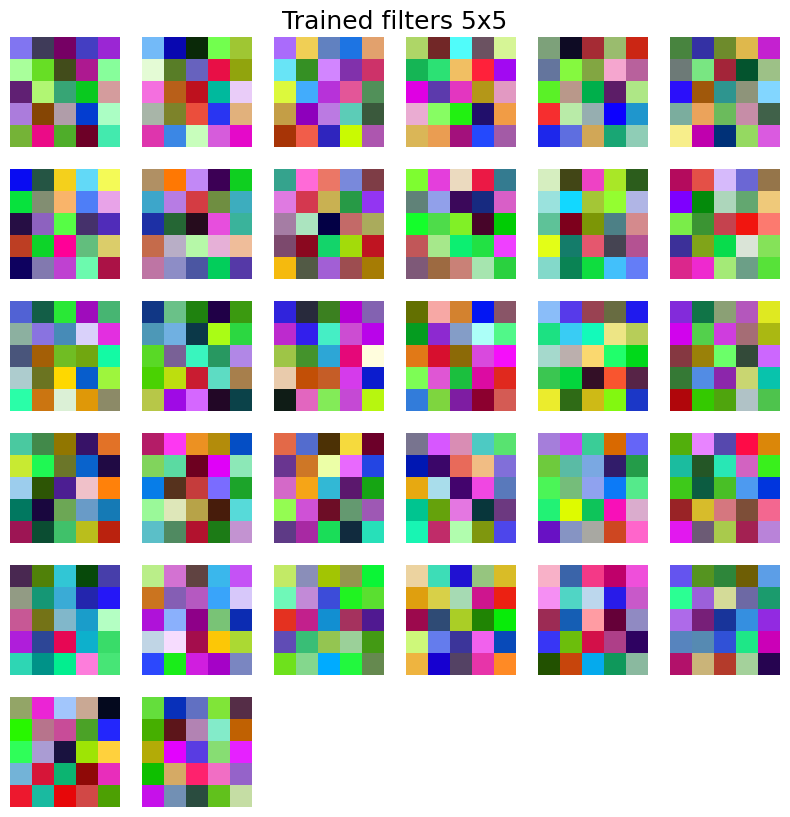

(9, 9, 3, 32)
(32, 9, 9, 3)


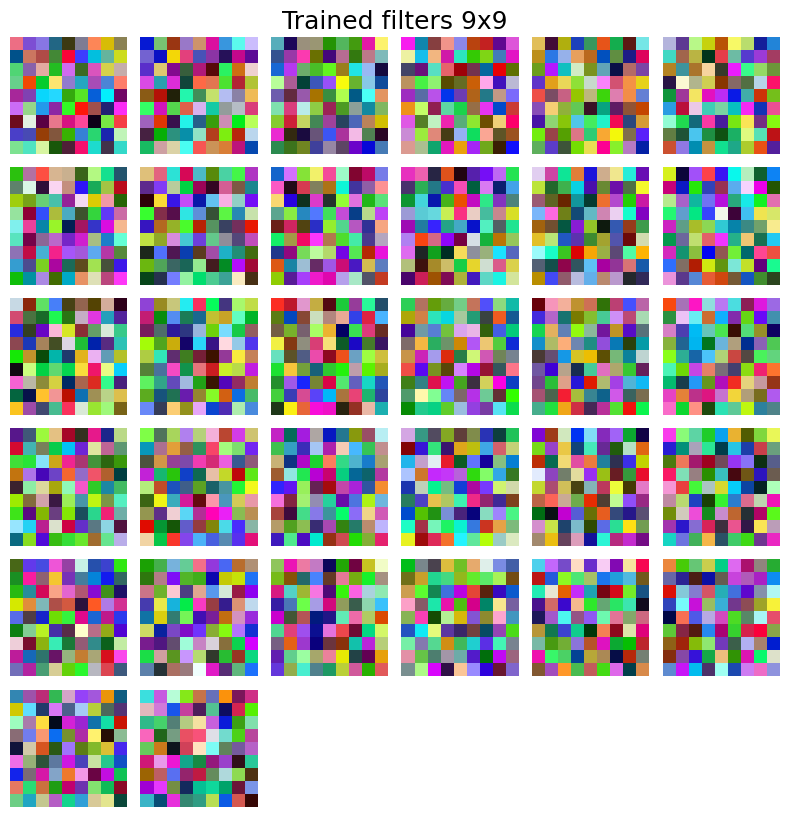

(13, 13, 3, 32)
(32, 13, 13, 3)


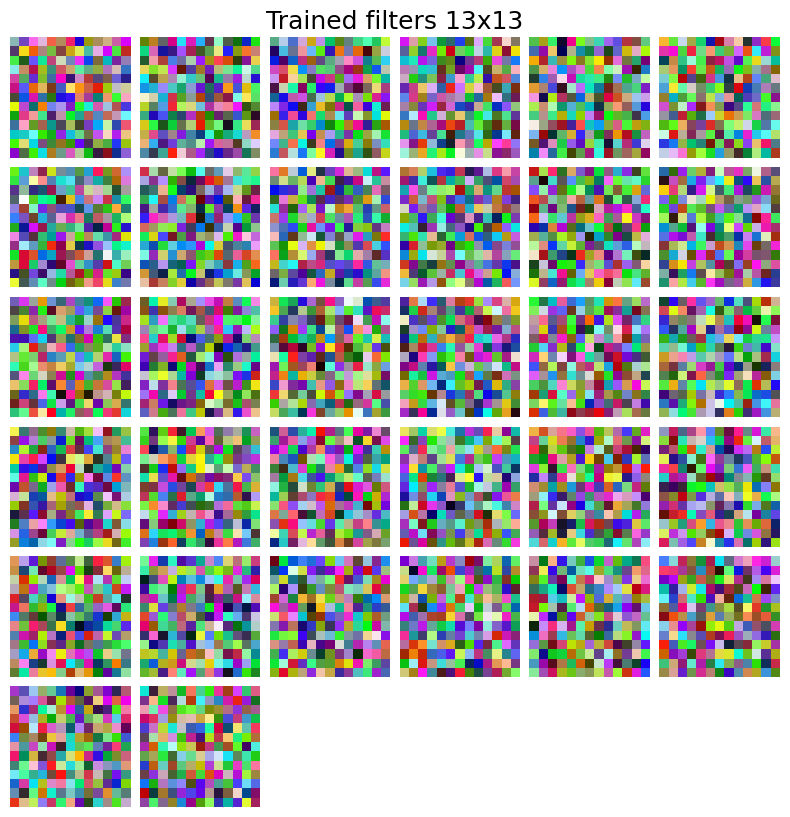

(15, 15, 3, 32)
(32, 15, 15, 3)


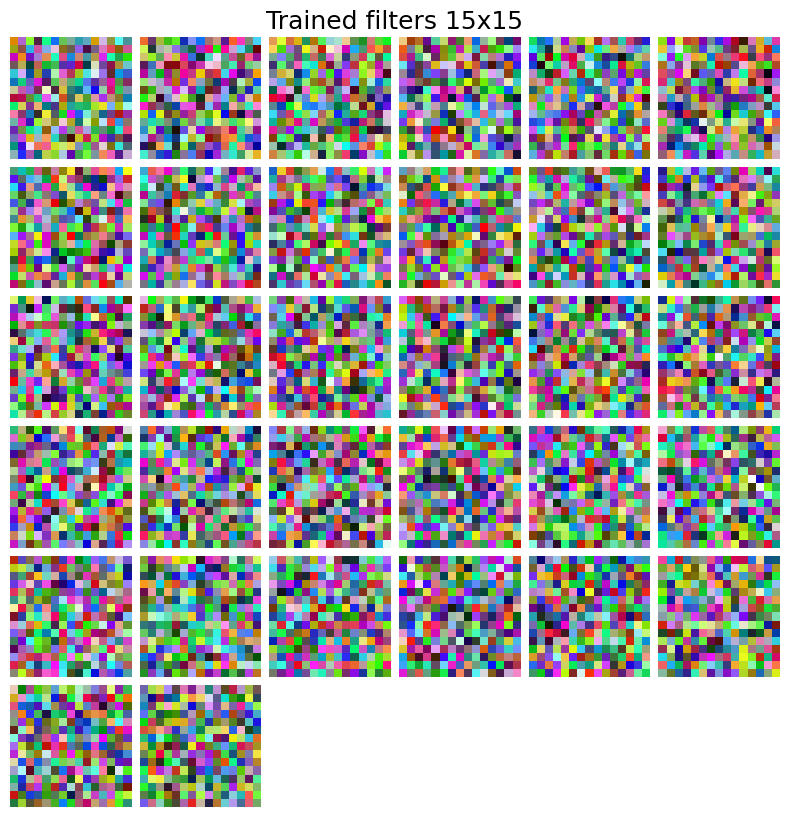

(19, 19, 3, 32)
(32, 19, 19, 3)


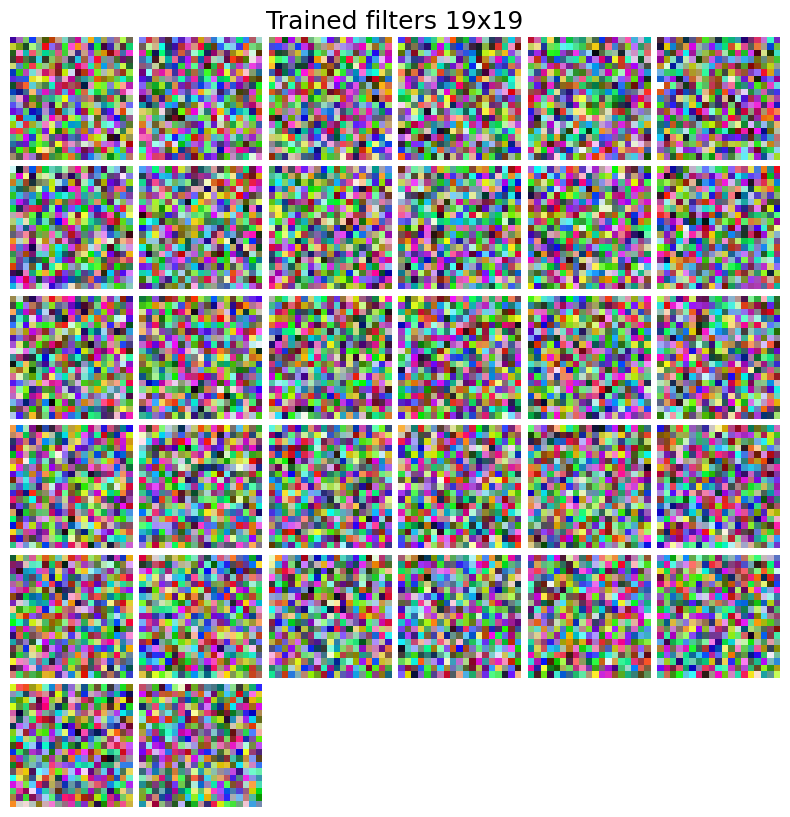

(23, 23, 3, 32)
(32, 23, 23, 3)


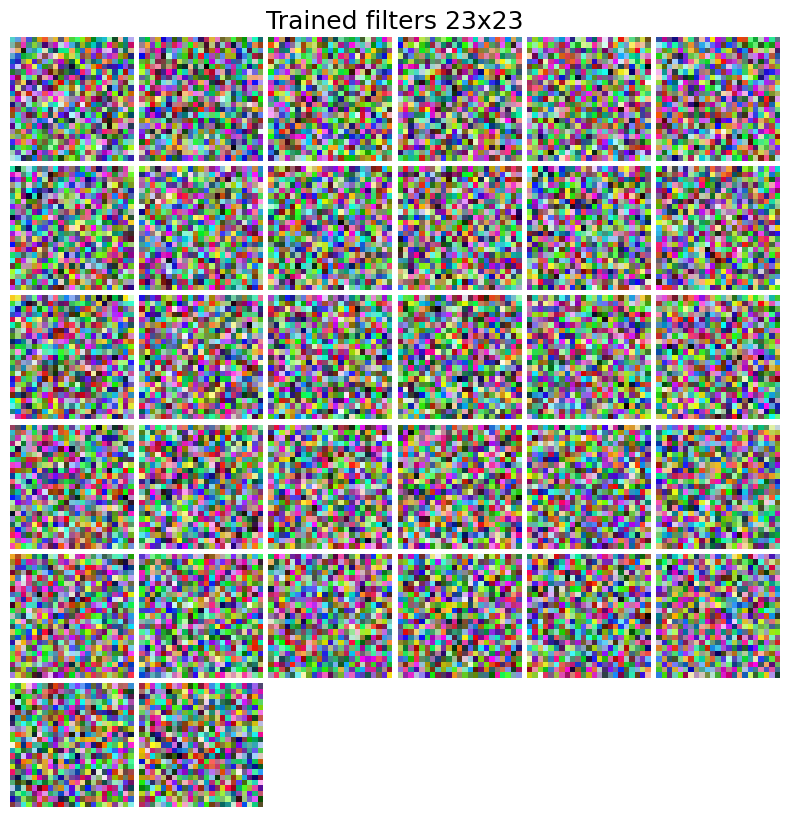

(25, 25, 3, 32)
(32, 25, 25, 3)


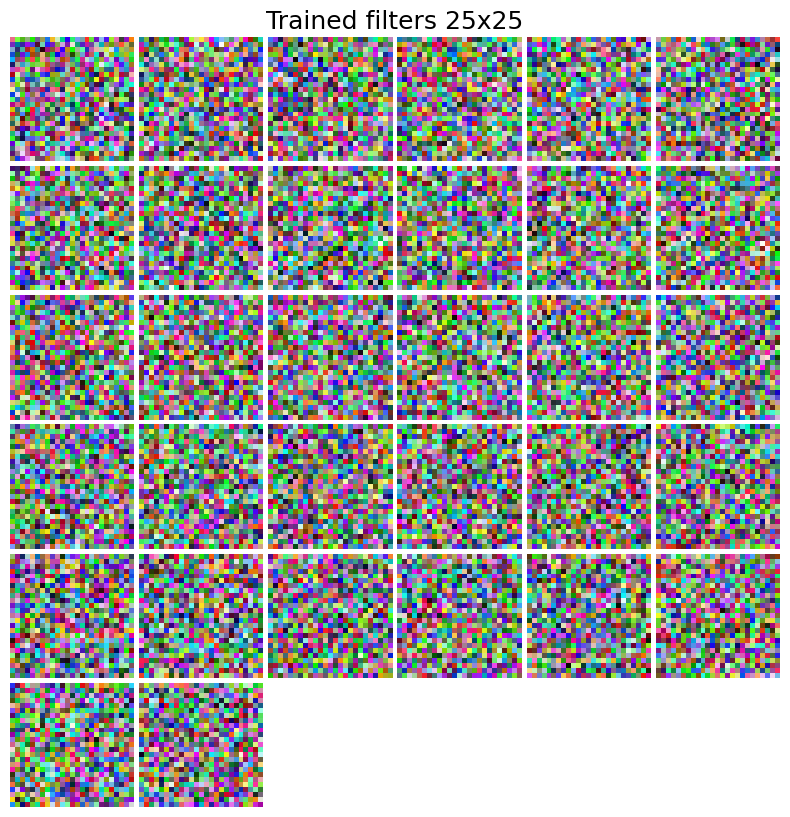

(31, 31, 3, 32)
(32, 31, 31, 3)


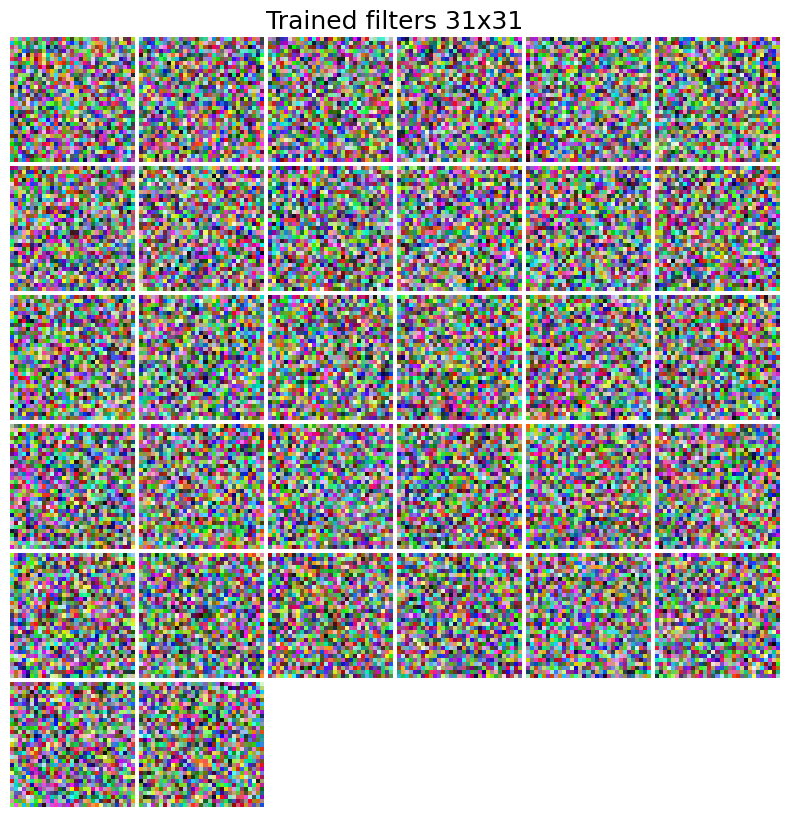

In [31]:
for i in range(len(model)):
    w = model[i].get_weights()
    print(w[0].shape)
    # print(model[i].get_config())
    # l = model[i].layers
    # print(l[0].get_weights()[0].shape)

    # Visualizing filters
    temp = w[0].transpose(3, 0, 1, 2)
    print(temp.shape)  # (81, 32, 32, 3)

    # Plotting
    fig = plt.figure()
    grid = convert_to_grid(temp)
    plt.imshow(grid.astype('uint8'), cmap='gray')
    plt.axis('off')
    plt.gcf().set_size_inches(10, 10)
    name = 'Trained filters ' + str(filters[i]) + 'x' + str(filters[i])
    plt.title(name, fontsize=18)
    
    # Showing the plot
    plt.show()

    # Saving the plot
    name = 'filters-' + str(filters[i]) + 'x' + str(filters[i]) + '.png'
    fig.savefig(name)
    plt.close()

(1, 32, 32, 3)
[3]


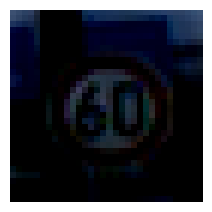

1/1 [==============================] - 0s 202ms/step
(43,)
ClassId: 3
Label: Speed limit (60km/h)


In [30]:
%matplotlib inline

# Preparing image for predicting from test dataset
x_input = data['x_test'][100:101]
print(x_input.shape)
y_input = data['y_test'][100:101]
print(y_input)

plt.rcParams['figure.figsize'] = (2.5, 2.5) # Setting default size of plots
plt.imshow(x_input[0, :, :, :])
plt.axis('off')

# Showing the plot
plt.show()

# Getting scores from forward pass of input image
scores = model[0].predict(x_input)
print(scores[0].shape) # (43,)

# Scores is given for image with 43 numbers of predictions for each class
# Getting only one class with maximum value
prediction = np.argmax(scores)
print('ClassId:', prediction)

# Defining function for getting texts for every class - labels
def label_text(file):
    # Defining list for saving label in order from 0 to 42
    label_list = []
    
    # Reading 'csv' file and getting image's labels
    r = pd.read_csv(file)
    # Going through all names
    for name in r['SignName']:
        # Adding from every row second column with name of the label
        label_list.append(name)
    
    # Returning resulted list with labels
    return label_list


# Getting labels
labels = label_text('/content/sample_data/label_names.csv')

# Printing label for classified Traffic Sign
print('Label:', labels[prediction])

In [29]:
for i in range(len(model)):
    name = 'model-' + str(filters[i]) + 'x' + str(filters[i]) + '.h5'
    model[i].save(name)

# # Saving model locally without committing
# from IPython.display import FileLink

# FileLink('model-3x3.h5')